# Classifiying the tweets using BERT

In [1]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
import tqdm
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from wordcloud import WordCloud
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import tokenization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Loading data

In [3]:
train_data = pd.read_csv("../input/tweets-with-sarcasm-and-irony/train.csv")
test_data = pd.read_csv("../input/tweets-with-sarcasm-and-irony/test.csv")

### Remove recurring tweets to prevent ambiguity

In [4]:
train_tweets=train_data['tweets'].tolist()
test_tweets=test_data['tweets'].tolist()

In [5]:
def keep_uniques(array, df):
    dels=[]
    for i in array:
        if array.count(i)>1:
            dels.append(i)
    dels=list(set(dels))
    for i in dels:
        df.drop( df[ df['tweets'] == i ].index, inplace=True)
    return df

In [6]:
train_data=keep_uniques(train_tweets, train_data)
test_data=keep_uniques(test_tweets, test_data)

In [7]:
len(train_data['tweets'].unique())

54618

In [8]:
len(test_data['tweets'].unique())

7861

### Dataset details

In [9]:
train_data.describe()

,tweets,class
count,54618,54618
unique,54618,4
top,A Peacock in the Land of Penguins by BJ Gallag...,regular
freq,1,18557


In [10]:
train_data = train_data.sample(frac = 1)
test_data = test_data.sample(frac = 1)

In [11]:
train_data.head()

,tweets,class
48432,“@nytimes: Quote of the Day http://t.co/NbSdsd...,regular
39357,Hard not to love the #irony of #MotherTeresa o...,irony
46575,Trump Persuasion Alert: Bible Dodge: If you ha...,regular
79914,I still can't believe @officialgtfc season is ...,sarcasm
39677,Pitching an already successful model is toughe...,irony


In [12]:
test_data.head()

,tweets,class
3068,Doing a dissertation has been one of my least...,irony
178,The fantastic @jordskott isn't at all ruined b...,figurative
6809,Michigan Politricks at its best. Wow. Just re...,sarcasm
7185,@ausceecee It is the perfect environment for h...,sarcasm
5578,Ripped from the interwebs\nInner Hugs\n#doctor...,regular


In [13]:
train_data['class'].value_counts()

regular       18557
sarcasm       15404
irony         12784
figurative     7873
Name: class, dtype: int64

Here, we see that the `regular` class has 18k tweets, which causes our dataset to be imbalanced. So we shall delete some tweets from this class

In [14]:
temp=train_data.loc[train_data['class'] == 'regular']

In [15]:
lis=temp['tweets'].tolist()

In [16]:
import random
reg_del=[]
visited=set()
for _ in range(3600):
    n=random.randint(0,18556)
    if n not in visited:
        reg_del.append(lis[n])
        
        
for i in reg_del:
    train_data.drop( train_data[ train_data['tweets'] == i ].index, inplace=True)

In [17]:
train_data['class'].value_counts()

sarcasm       15404
regular       15287
irony         12784
figurative     7873
Name: class, dtype: int64

In [18]:
test_data['class'].value_counts()

sarcasm       2054
irony         2029
figurative    1911
regular       1859
Name: class, dtype: int64

## Data Cleaning Preprocessing

In [19]:
def remove_URL(text):
    text=str(text)
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_mentions(text):
    ment = re.compile(r"(@[A-Za-z0-9]+)")
    return ment.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

In [20]:
train_data['clean_text'] = train_data['tweets'].apply(lambda x: remove_URL(x))
train_data['clean_text'] = train_data['clean_text'].apply(lambda x: remove_emoji(x))
train_data['clean_text'] = train_data['clean_text'].apply(lambda x: remove_html(x))
train_data['clean_text'] = train_data['clean_text'].apply(lambda x: remove_mentions(x))
train_data['clean_text'] = train_data['clean_text'].apply(lambda x: remove_punct(x))
train_data['clean_text'] = train_data['clean_text'].apply(
    lambda x: x.lower())

In [21]:
cleaned = train_data['clean_text'].tolist()

for i,text in enumerate(cleaned):
    splits = text.split()
    splits = [word for word in splits if word not in set(nltk.corpus.stopwords.words('english'))]
    cleaned[i]=' '.join(splits)
    
train_data['clean_text']=cleaned
    

In [22]:
train_data.head()

,tweets,class,clean_text
48432,“@nytimes: Quote of the Day http://t.co/NbSdsd...,regular,“ quote day marijuana say drugs drugmedown
39357,Hard not to love the #irony of #MotherTeresa o...,irony,hard love irony motherteresa 20 gopdebate
46575,Trump Persuasion Alert: Bible Dodge: If you ha...,regular,trump persuasion alert bible dodge following a...
79914,I still can't believe @officialgtfc season is ...,sarcasm,still cant believe season 7matches 2wins 2lose...
39677,Pitching an already successful model is toughe...,irony,pitching already successful model tougher pitc...


In [23]:
test_data['clean_text'] = test_data['tweets'].apply(lambda x: remove_URL(x))
test_data['clean_text'] = test_data['clean_text'].apply(lambda x: remove_emoji(x))
test_data['clean_text'] = test_data['clean_text'].apply(lambda x: remove_html(x))
test_data['clean_text'] = test_data['clean_text'].apply(lambda x: remove_mentions(x))
test_data['clean_text'] = test_data['clean_text'].apply(lambda x: remove_punct(x))
test_data['clean_text'] = test_data['clean_text'].apply(
    lambda x: x.lower())

In [24]:
cleaned = test_data['clean_text'].tolist()

for i,text in enumerate(cleaned):
    splits = text.split()
    splits = [word for word in splits if word not in set(nltk.corpus.stopwords.words('english'))]
    cleaned[i]=' '.join(splits)
    
test_data['clean_text']=cleaned

In [25]:
test_data.head()

,tweets,class,clean_text
3068,Doing a dissertation has been one of my least...,irony,dissertation one least favorite experiences to...
178,The fantastic @jordskott isn't at all ruined b...,figurative,fantastic isnt ruined large logo new exclusive...
6809,Michigan Politricks at its best. Wow. Just re...,sarcasm,michigan politricks best wow remember apologiz...
7185,@ausceecee It is the perfect environment for h...,sarcasm,perfect environment sarcasm really want true
5578,Ripped from the interwebs\nInner Hugs\n#doctor...,regular,ripped interwebs inner hugs doctor inners grap...


In [26]:
test_data = test_data.dropna()

### Basic EDA

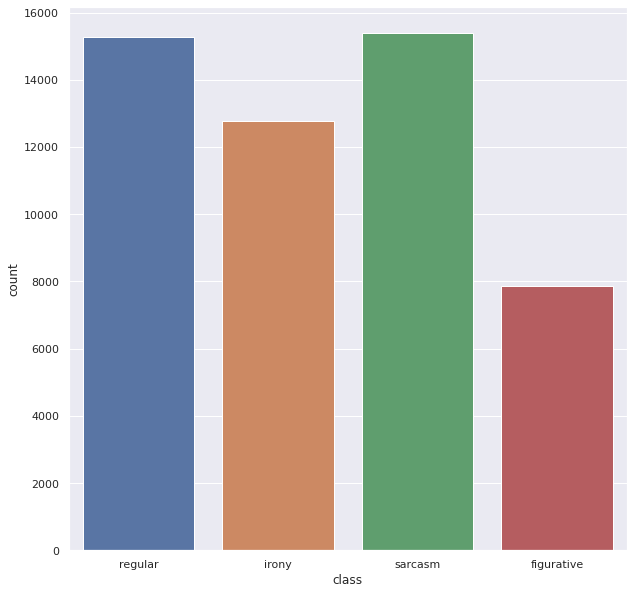

In [27]:
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(train_data['class'])

### Word cloud for regular class

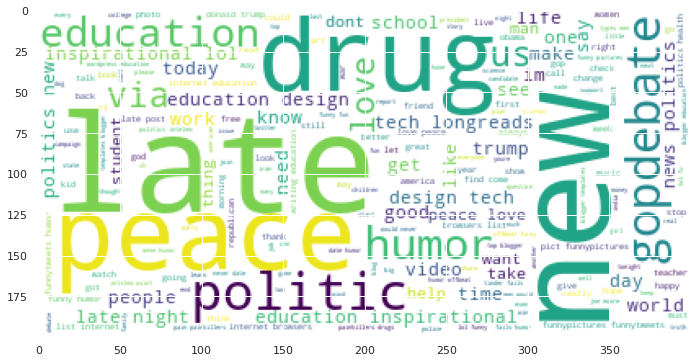

In [28]:
from wordcloud import WordCloud
stopwords = nltk.corpus.stopwords.words('english')

plt.figure(figsize=(12,6))
text = ' '.join(train_data.clean_text[train_data['class']=='regular'])
wc = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc)

### Word cloud for irony class

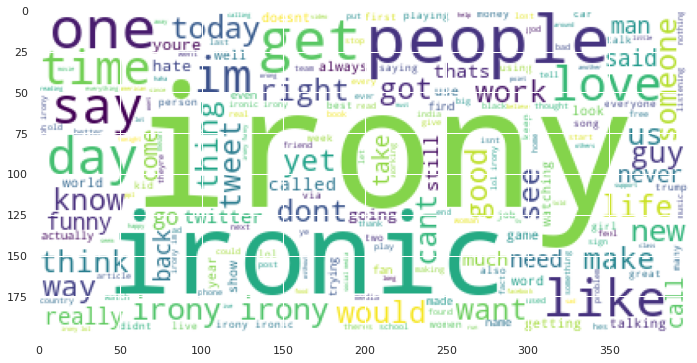

In [29]:
plt.figure(figsize=(12,6))
text = ' '.join(train_data.clean_text[train_data['class']=='irony'])
wc = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc)

### Word cloud for sarcasm class

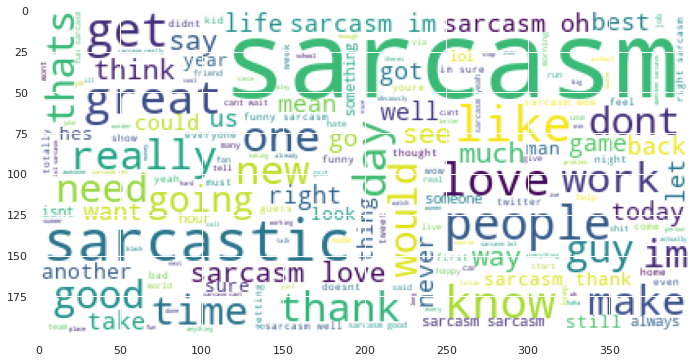

In [30]:
plt.figure(figsize=(12,6))
text = ' '.join(train_data.clean_text[train_data['class']=='sarcasm'])
wc = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc)

### Word cloud for figurative class

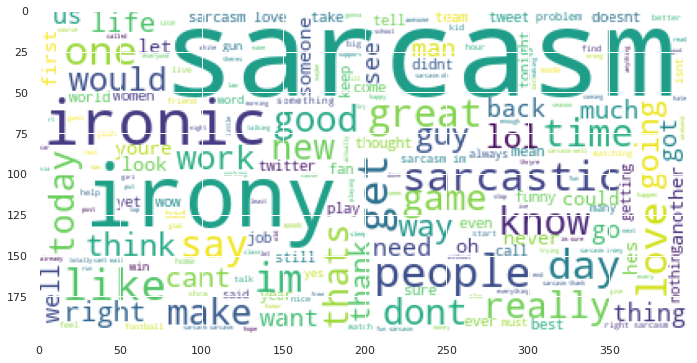

In [31]:
plt.figure(figsize=(12,6))
text = ' '.join(train_data.clean_text[train_data['class']=='figurative'])
wc = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc)

## BERT Embeddings

In [32]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens, all_masks, all_segments = [], [], []
    
    for text in tqdm(texts):
        # Tokenize the current text
        text = tokenizer.tokenize(text)
        # Select text only till 
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

### Get BERT Model from TFHub

In [33]:
%%time
url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(url, trainable=True)

CPU times: user 31.9 s, sys: 8.61 s, total: 40.5 s
Wall time: 51.6 s


In [34]:
# Get tokenizer
vocab_fl = bert_layer.resolved_object.vocab_file.asset_path.numpy()
lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_fl, lower_case)

### Encoding the texts

In [35]:
def encode_target(t_class):
    t_class=str(t_class)
    class_dict = {
        'irony':0,
        'sarcasm':1,
        'regular':2,
        'figurative':3
    }
    return class_dict[t_class]

In [36]:
train_data["target"] = train_data['class'].apply(lambda x: encode_target(x))
test_data["target"] = test_data['class'].apply(lambda x: encode_target(x))

In [37]:
%%time
train_input = bert_encode(train_data['clean_text'].values, tokenizer, max_len=160)
test_input = bert_encode(test_data['clean_text'].values, tokenizer, max_len=160)
train_labels = train_data['target'].values
test_labels = test_data['target'].values


CPU times: user 27.9 s, sys: 377 ms, total: 28.3 s
Wall time: 28.5 s


### Fine tuned model

In [38]:
def build_model(transformer, max_len=512):

    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_word_ids')
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name='input_mask')
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name='segment_ids')
    # Get the sequence output
    _, seq_op = transformer([input_word_ids, input_mask, segment_ids])
    # Get the respective class token from that sequence output
    class_tkn = seq_op[:, 0, :]
    # Final Neuron (for Classification)
    op = Dense(4, activation='softmax')(class_tkn)
    # Bind the inputs and outputs together into a Model
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=op)
    
    model.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [39]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [40]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

train_history = model.fit(
    train_input, train_labels,
    validation_split=0.10,
    epochs=4,
    callbacks=[checkpoint],
    batch_size=16
)

Epoch 1/4
2889/2889 [==============================] - 2750s 952ms/step - loss: 0.4026 - accuracy: 0.8356 - val_loss: 0.3802 - val_accuracy: 0.8419
Epoch 2/4
2889/2889 [==============================] - 2712s 939ms/step - loss: 0.3664 - accuracy: 0.8482 - val_loss: 0.3827 - val_accuracy: 0.8434
Epoch 3/4
2889/2889 [==============================] - 2710s 938ms/step - loss: 0.3500 - accuracy: 0.8542 - val_loss: 0.3946 - val_accuracy: 0.8315
Epoch 4/4
2889/2889 [==============================] - 2712s 939ms/step - loss: 0.2309 - accuracy: 0.9065 - val_loss: 0.5055 - val_accuracy: 0.8121


In [41]:
scores = model.evaluate(test_input, test_labels, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 59.81%
